<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

## *Data Science Unit 1 Sprint 3 Assignment 1*

# Apply the t-test to real data

Your assignment is to determine which issues have "statistically significant" differences between political parties in this [1980s congressional voting data](https://archive.ics.uci.edu/ml/datasets/Congressional+Voting+Records). The data consists of 435 instances (one for each congressperson), a class (democrat or republican), and 16 binary attributes (yes or no for voting for or against certain issues). Be aware - there are missing values!

Your goals:

1. Load and clean the data (or determine the best method to drop observations when running tests)
2. Using hypothesis testing, find an issue that democrats support more than republicans with p < 0.01
3. Using hypothesis testing, find an issue that republicans support more than democrats with p < 0.01
4. Using hypothesis testing, find an issue where the difference between republicans and democrats has p > 0.1 (i.e. there may not be much of a difference)

Note that this data will involve *2 sample* t-tests, because you're comparing averages across two groups (republicans and democrats) rather than a single group against a null hypothesis.

Stretch goals:

1. Refactor your code into functions so it's easy to rerun with arbitrary variables
2. Apply hypothesis testing to your personal project data (for the purposes of this notebook you can type a summary of the hypothesis you formed and tested)

In [1]:
!curl https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.names

1. Title: 1984 United States Congressional Voting Records Database

2. Source Information:
    (a) Source:  Congressional Quarterly Almanac, 98th Congress, 
                 2nd session 1984, Volume XL: Congressional Quarterly Inc. 
                 Washington, D.C., 1985.
    (b) Donor: Jeff Schlimmer (Jeffrey.Schlimmer@a.gp.cs.cmu.edu)
    (c) Date: 27 April 1987 

3. Past Usage
   - Publications
     1. Schlimmer, J. C. (1987).  Concept acquisition through 
        representational adjustment.  Doctoral dissertation, Department of 
        Information and Computer Science, University of California, Irvine, CA.
        -- Results: about 90%-95% accuracy appears to be STAGGER's asymptote
     - Predicted attribute: party affiliation (2 classes)

4. Relevant Information:
      This data set includes votes for each of the U.S. House of
      Representatives Congressmen on the 16 key votes identified by the
      CQA.  The CQA lists nine different types of votes: voted for, paired
      

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, ttest_rel

In [0]:



url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data'
cols = ['Class Name', 'handicapped_infants', 'water_cost_sharing', 'adopt_budget_res', 'doc_fee_freeze', 'el_salvador_aid', 'religion_in_school',
       'anti_satellite_test_ban', 'aid_nicaraguan_contras', 'mx_missile', 'immigration', 'synfuels_corp_cuts', 'edu_spending', 'superfund_right_to_sue', 'crime', 'duty_free_export', 'exp_admin_act_s_africa']
df = pd.read_csv(url, header=None, names=cols, na_values='?')

In [4]:
print(df.shape)
df.head()

(435, 17)


,Class Name,handicapped_infants,water_cost_sharing,adopt_budget_res,doc_fee_freeze,el_salvador_aid,religion_in_school,anti_satellite_test_ban,aid_nicaraguan_contras,mx_missile,immigration,synfuels_corp_cuts,edu_spending,superfund_right_to_sue,crime,duty_free_export,exp_admin_act_s_africa
0,republican,n,y,n,y,y,y,n,n,n,y,NaN,y,y,y,n,y
1,republican,n,y,n,y,y,y,n,n,n,n,n,y,y,y,n,NaN
2,democrat,NaN,y,y,NaN,y,y,n,n,n,n,y,n,y,y,n,n
3,democrat,n,y,y,n,NaN,y,n,n,n,n,y,n,y,n,n,y
4,democrat,y,y,y,n,y,y,n,n,n,n,y,NaN,y,y,y,y


In [5]:
df.isna().sum()

Class Name                   0
handicapped_infants         12
water_cost_sharing          48
adopt_budget_res            11
doc_fee_freeze              11
el_salvador_aid             15
religion_in_school          11
anti_satellite_test_ban     14
aid_nicaraguan_contras      15
mx_missile                  22
immigration                  7
synfuels_corp_cuts          21
edu_spending                31
superfund_right_to_sue      25
crime                       17
duty_free_export            28
exp_admin_act_s_africa     104
dtype: int64

In [6]:
df.describe()

,Class Name,handicapped_infants,water_cost_sharing,adopt_budget_res,doc_fee_freeze,el_salvador_aid,religion_in_school,anti_satellite_test_ban,aid_nicaraguan_contras,mx_missile,immigration,synfuels_corp_cuts,edu_spending,superfund_right_to_sue,crime,duty_free_export,exp_admin_act_s_africa
count,435,423,387,424,424,420,424,421,420,413,428,414,404,410,418,407,331
unique,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
top,democrat,n,y,y,n,y,y,y,y,y,y,n,n,y,y,n,y
freq,267,236,195,253,247,212,272,239,242,207,216,264,233,209,248,233,269


In [0]:
democrat = df[df['Class Name'] == 'democrat']
republican = df[df['Class Name'] == 'republican']

In [8]:
print(democrat.shape)
print(democrat.describe())
democrat.head()

(267, 17)
       Class Name handicapped_infants  ... duty_free_export exp_admin_act_s_africa
count         267                 258  ...              251                    185
unique          1                   2  ...                2                      2
top      democrat                   y  ...                y                      y
freq          267                 156  ...              160                    173

[4 rows x 17 columns]


,Class Name,handicapped_infants,water_cost_sharing,adopt_budget_res,doc_fee_freeze,el_salvador_aid,religion_in_school,anti_satellite_test_ban,aid_nicaraguan_contras,mx_missile,immigration,synfuels_corp_cuts,edu_spending,superfund_right_to_sue,crime,duty_free_export,exp_admin_act_s_africa
2,democrat,NaN,y,y,NaN,y,y,n,n,n,n,y,n,y,y,n,n
3,democrat,n,y,y,n,NaN,y,n,n,n,n,y,n,y,n,n,y
4,democrat,y,y,y,n,y,y,n,n,n,n,y,NaN,y,y,y,y
5,democrat,n,y,y,n,y,y,n,n,n,n,n,n,y,y,y,y
6,democrat,n,y,n,y,y,y,n,n,n,n,n,n,NaN,y,y,y


In [9]:
print(republican.shape)
print(republican.describe())
republican.head()

(168, 17)
        Class Name handicapped_infants  ... duty_free_export exp_admin_act_s_africa
count          168                 165  ...              156                    146
unique           1                   2  ...                2                      2
top     republican                   n  ...                n                      y
freq           168                 134  ...              142                     96

[4 rows x 17 columns]


,Class Name,handicapped_infants,water_cost_sharing,adopt_budget_res,doc_fee_freeze,el_salvador_aid,religion_in_school,anti_satellite_test_ban,aid_nicaraguan_contras,mx_missile,immigration,synfuels_corp_cuts,edu_spending,superfund_right_to_sue,crime,duty_free_export,exp_admin_act_s_africa
0,republican,n,y,n,y,y,y,n,n,n,y,NaN,y,y,y,n,y
1,republican,n,y,n,y,y,y,n,n,n,n,n,y,y,y,n,NaN
7,republican,n,y,n,y,y,y,n,n,n,n,n,n,y,y,NaN,y
8,republican,n,y,n,y,y,y,n,n,n,n,n,y,y,y,n,y
10,republican,n,y,n,y,y,n,n,n,n,n,NaN,NaN,y,y,n,n


In [10]:
republican['handicapped_infants'].value_counts()

n    134
y     31
Name: handicapped_infants, dtype: int64

In [11]:
mapping = {'n': 0, 'y': 1}

for col in democrat.columns:
  if col != 'Class Name':
    democrat.replace({col: mapping}, inplace=True)
  

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:6517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  regex=regex)


In [12]:
for col in republican.columns:
  if col != 'Class Name':
    republican.replace({col: mapping}, inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:6517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  regex=regex)


In [13]:
democrat.head()

,Class Name,handicapped_infants,water_cost_sharing,adopt_budget_res,doc_fee_freeze,el_salvador_aid,religion_in_school,anti_satellite_test_ban,aid_nicaraguan_contras,mx_missile,immigration,synfuels_corp_cuts,edu_spending,superfund_right_to_sue,crime,duty_free_export,exp_admin_act_s_africa
2,democrat,NaN,1.0,1.0,NaN,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
3,democrat,0.0,1.0,1.0,0.0,NaN,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,democrat,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,1.0
5,democrat,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
6,democrat,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,1.0,1.0,1.0


In [14]:
republican.head()

,Class Name,handicapped_infants,water_cost_sharing,adopt_budget_res,doc_fee_freeze,el_salvador_aid,religion_in_school,anti_satellite_test_ban,aid_nicaraguan_contras,mx_missile,immigration,synfuels_corp_cuts,edu_spending,superfund_right_to_sue,crime,duty_free_export,exp_admin_act_s_africa
0,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,0.0,1.0
1,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,NaN
7,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,NaN,1.0
8,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0
10,republican,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,1.0,0.0,0.0


In [0]:
import random
def fillnan(df):
  for col in df.columns:
    df[col].fillna(random.randint(0,1), inplace=True)
  return df    

In [16]:
democrat = fillnan(democrat)
republican = fillnan(republican)

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [17]:
print(democrat.isna().sum())
print(republican.isna().sum())

Class Name                 0
handicapped_infants        0
water_cost_sharing         0
adopt_budget_res           0
doc_fee_freeze             0
el_salvador_aid            0
religion_in_school         0
anti_satellite_test_ban    0
aid_nicaraguan_contras     0
mx_missile                 0
immigration                0
synfuels_corp_cuts         0
edu_spending               0
superfund_right_to_sue     0
crime                      0
duty_free_export           0
exp_admin_act_s_africa     0
dtype: int64
Class Name                 0
handicapped_infants        0
water_cost_sharing         0
adopt_budget_res           0
doc_fee_freeze             0
el_salvador_aid            0
religion_in_school         0
anti_satellite_test_ban    0
aid_nicaraguan_contras     0
mx_missile                 0
immigration                0
synfuels_corp_cuts         0
edu_spending               0
superfund_right_to_sue     0
crime                      0
duty_free_export           0
exp_admin_act_s_africa     0
d

In [18]:
print('Democrats: {}'.format(democrat['handicapped_infants'].value_counts()))

print('Republicans: {}'.format(republican['handicapped_infants'].value_counts()))

Democrats: 1.0    156
0.0    111
Name: handicapped_infants, dtype: int64
Republicans: 0.0    134
1.0     34
Name: handicapped_infants, dtype: int64


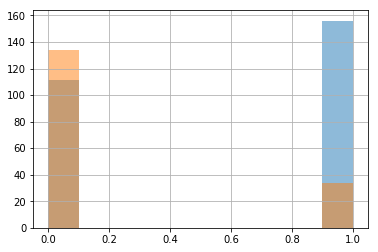

In [19]:
# 1 = yes, 0 = no
democrat['handicapped_infants'].hist(alpha=0.5)
republican['handicapped_infants'].hist(alpha=0.5)

In [36]:
voting_means = pd.DataFrame([democrat.mean(), republican.mean()], index=['democrat', 'republican'])
voting_means = voting_means.T
voting_means

,democrat,republican
handicapped_infants,0.584270,0.202381
water_cost_sharing,0.554307,0.565476
adopt_budget_res,0.891386,0.130952
doc_fee_freeze,0.082397,0.970238
el_salvador_aid,0.205993,0.934524
religion_in_school,0.494382,0.886905
anti_satellite_test_ban,0.779026,0.232143
aid_nicaraguan_contras,0.816479,0.208333
mx_missile,0.704120,0.113095
immigration,0.464419,0.547619


In [38]:
mean_diff = voting_means['democrat'] - voting_means['republican']
mean_diff


handicapped_infants        0.381889
water_cost_sharing        -0.011169
adopt_budget_res           0.760433
doc_fee_freeze            -0.887841
el_salvador_aid           -0.728531
religion_in_school        -0.392523
anti_satellite_test_ban    0.546883
aid_nicaraguan_contras     0.608146
mx_missile                 0.591025
immigration               -0.083200
synfuels_corp_cuts         0.349518
edu_spending              -0.746121
superfund_right_to_sue    -0.539460
crime                     -0.607611
duty_free_export           0.515918
exp_admin_act_s_africa    -0.054441
dtype: float64

In [41]:
ttest, pvalue = ttest_ind(voting_means['democrat'], voting_means['republican'])

print(ttest)
print(pvalue)

-0.17290513473841268
0.8638872915996475


In [45]:
ttest_rel, pvalue_rel = ttest_rel(voting_means['democrat'], voting_means['republican'])

print(ttest_rel)
print(pvalue_rel)

-0.13095109860029883
0.897554145388832


In [0]:
# ttest, pvalue = ttest_ind(voting_means[voting_means['democrat']]['water_cost_sharing'], voting_means[voting_means['republican']]['water_cost_sharing'])

# print(ttest)
# print(pvalue)

In [60]:
ndf = pd.concat([democrat, republican])
print(new_df.shape)
print(new_df.isna().sum())
ndf.head()

(435, 17)
Class Name                 0
handicapped_infants        0
water_cost_sharing         0
adopt_budget_res           0
doc_fee_freeze             0
el_salvador_aid            0
religion_in_school         0
anti_satellite_test_ban    0
aid_nicaraguan_contras     0
mx_missile                 0
immigration                0
synfuels_corp_cuts         0
edu_spending               0
superfund_right_to_sue     0
crime                      0
duty_free_export           0
exp_admin_act_s_africa     0
dtype: int64


,Class Name,handicapped_infants,water_cost_sharing,adopt_budget_res,doc_fee_freeze,el_salvador_aid,religion_in_school,anti_satellite_test_ban,aid_nicaraguan_contras,mx_missile,immigration,synfuels_corp_cuts,edu_spending,superfund_right_to_sue,crime,duty_free_export,exp_admin_act_s_africa
2,democrat,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
3,democrat,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,democrat,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0
5,democrat,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
6,democrat,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0


In [64]:
democrat.sum()

Class Name                 democratdemocratdemocratdemocratdemocratdemocr...
handicapped_infants                                                      156
water_cost_sharing                                                       148
adopt_budget_res                                                         238
doc_fee_freeze                                                            22
el_salvador_aid                                                           55
religion_in_school                                                       132
anti_satellite_test_ban                                                  208
aid_nicaraguan_contras                                                   218
mx_missile                                                               188
immigration                                                              124
synfuels_corp_cuts                                                       141
edu_spending                                                              36

In [0]:
dfa = pd.DataFrame({'Dem Yes': })